In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from gait import preprocess,fetch_labels
from utils import *
import cv2
# from torchvision import transforms

In [2]:
# paths = get_keyposepath()

In [3]:
os.chdir('/home/ishikaa/Downloads/')
labels = fetch_labels(label_angle='000',save=False,override=True)
files = [filename for filename, _ in labels.items()]

100%|██████████| 124/124 [00:00<00:00, 464.22it/s]


In [17]:

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [18]:
ae = Autoencoder()
device = get_device()
print(device)
ae.to(device)

cuda:0


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [19]:
class MyDataset():

    def __init__(self, files,transform=None):
        """
        Custom dataset for images of a certain keypose at a given angle.

        Args:
            angle (int)     : Angle
            keypose (int)   : Key-pose/Cluster
            data_path (str) : Path where dataset is downloaded
        """
        self.images = [preprocess(cv2.imread(file))/255 for file in files]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = image.reshape(1,image.shape[0],image.shape[1])
        return image


In [20]:
train = files[:8000]
test = files[8000:10000]
data = MyDataset(train)
dl = torch.utils.data.DataLoader(data, 32, True)

#Loss function
criterion = nn.BCELoss()
#Optimizer
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)

In [21]:
dataiter = iter(dl)
images = dataiter.next()
images.dtype

torch.float64

In [22]:
ae = ae.double()

In [25]:
#Epochs
n_epochs = 15

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    #Training
    for data in dl:
        images = data
        images = images.to(device)
        optimizer.zero_grad()
        outputs = ae(images)
        # print('Outputs.shape: ',outputs.shape,' Targets shape: ',images.shape)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
          
    train_loss = train_loss/len(dl)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

KeyboardInterrupt: 

In [9]:
test_ds = MyDataset(test)
test_dl = torch.utils.data.DataLoader(test_ds,batch_size=32)

In [10]:
# cv2.imshow('',out.cpu().detach().numpy())
# # cv2.imshow('',)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [11]:
images.dtype

torch.float64

<class 'torch.Tensor'> torch.Size([32, 1, 160, 120])
Original Images


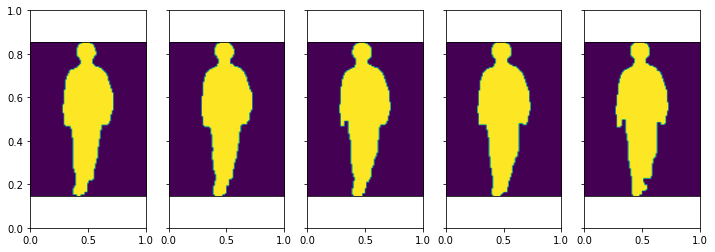

Reconstructed Images


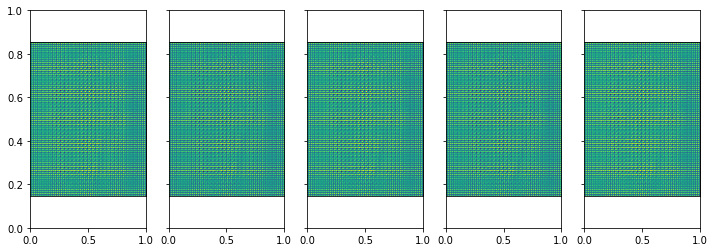

In [16]:
dataiter = iter(test_dl)
images = dataiter.next()
# images = images.to('cpu',dtype=torch.float)
print(type(images),images.shape)

model = model

#Sample outputs
output = model(images)
images = images.numpy()
batch_size = 32
output = output.view(batch_size, 1, 160, 120)
output = output.detach().numpy()

#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
plt.show() 

In [58]:
type(images)

numpy.ndarray

In [14]:
ae = ae.double()
torch.save(ae.state_dict(), '/home/ishikaa/Desktop/Repos/Gait-Occlusion-GAN/ae_dict')

In [15]:
device = torch.device('cpu')
model = Autoencoder().double()
model.load_state_dict(torch.load('/home/ishikaa/Desktop/Repos/Gait-Occlusion-GAN/encoder_dict', map_location=device))

<All keys matched successfully>